# Getting started

In [1]:
import pymultieis.multieis as pym
import numpy as np
import torch

In [2]:
# Load the file containing the frequencies
F = torch.as_tensor(np.load('../../../data/redox_exp_50/freq_50.npy'))
# Load the file containing the admittances (a set of 50 spectra)
Y = torch.as_tensor(np.load('../../../data/redox_exp_50/Y_50.npy'))
# Load the file containing the standard deviation of the admittances
Yerr = torch.as_tensor(np.load('../../../data/redox_exp_50/sigma_Y_50.npy'))


In [3]:
print(F.shape)
print(Y.shape)
print(Yerr.shape)

torch.Size([45])
torch.Size([45, 50])
torch.Size([45, 50])


In [4]:
par = lambda a, b: 1/(1/a + 1/b) # Defines the total impedance of circuit elements in parallel

def redox(p, f):
    w = 2*torch.pi*f                        # Angular frequency
    s = 1j*w                                # Complex variable
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rct = p[3]
    Wct = p[4]
    Rw = p[5]
    Zw = Wct/torch.sqrt(w) * (1-1j)         # Planar infinite length Warburg impedance
    Zdl = 1/(s**nh*Qh)                      # admittance of a CPE
    Z = Rs + par(Zdl, Rct + par(Zw, Rw))
    Y = 1/Z
    return torch.cat((Y.real, Y.imag), dim = 0)


In [5]:
# def redox(p, f):
#     w = 2*torch.pi*f               # Angular frequency
#     s = 1j*w                       # Complex variable
#     Rs = p[0]
#     Qh = p[1]
#     nh = p[2]
#     Rct = p[3]
#     Wct = p[4]
#     Rw = p[5]
#     Zw = Wct/torch.sqrt(w) * (1-1j) # Planar infinite length Warburg impedance
#     Ydl = (s**nh)*Qh                # admittance of a CPE
#     Z1 = (1/Zw + 1/Rw)**-1
#     Z2 = (Rct+Z1)
#     Y2 = Z2**-1
#     Y3 = (Ydl + Y2)
#     Z3 = 1/Y3
#     Z = Rs + Z3
#     Y = 1/Z
#     return torch.cat((Y.real, Y.imag), dim = 0)


In [6]:
p0 = torch.as_tensor([1.6295e+02, 3.0678e-08, 9.3104e-01, 1.1865e+04, 4.7125e+05, 1.3296e+06])

bounds = [[1e-15,1e15], [1e-9, 1e2], [1e-1,1e0], [1e-15,1e15], [1e-15,1e15], [1e-15,1e15]]

smf_sigma = torch.as_tensor([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.]) # Smoothing factor used with the standard deviation

smf_modulus = torch.as_tensor([1., 1., 1., 1., 1., 1.]) # Smoothing factor used with the modulus

labels = {"Rs":"$\Omega$", "Qh":"$F^{nh}$", "nh":"-", "Rct":"$\Omega$", "Wct":"$\Omega\cdot s^{-0.5}$", "Rw":"$\Omega$"}



1. using the standard deviation as weighting

In [7]:
eis_redox_sigma = pym.Multieis(p0, F, Y, bounds, smf_sigma, redox, weight= Yerr, immittance='admittance')

Iteration : 0, Loss : 4.69123e+04
Iteration : 595, Loss : 2.98005e+01
Optimization complete
total time is 0:01:12.948009 

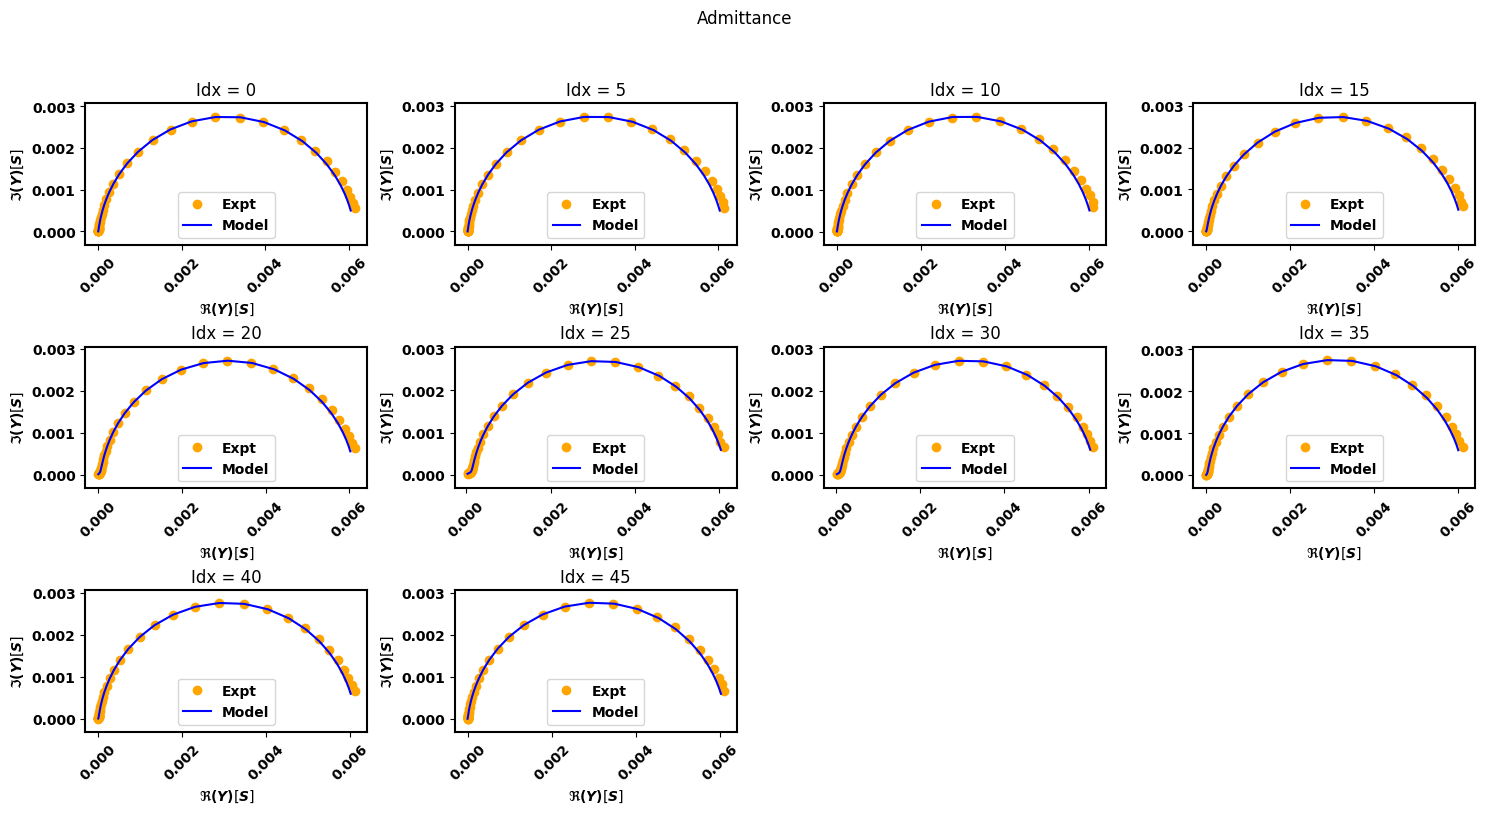

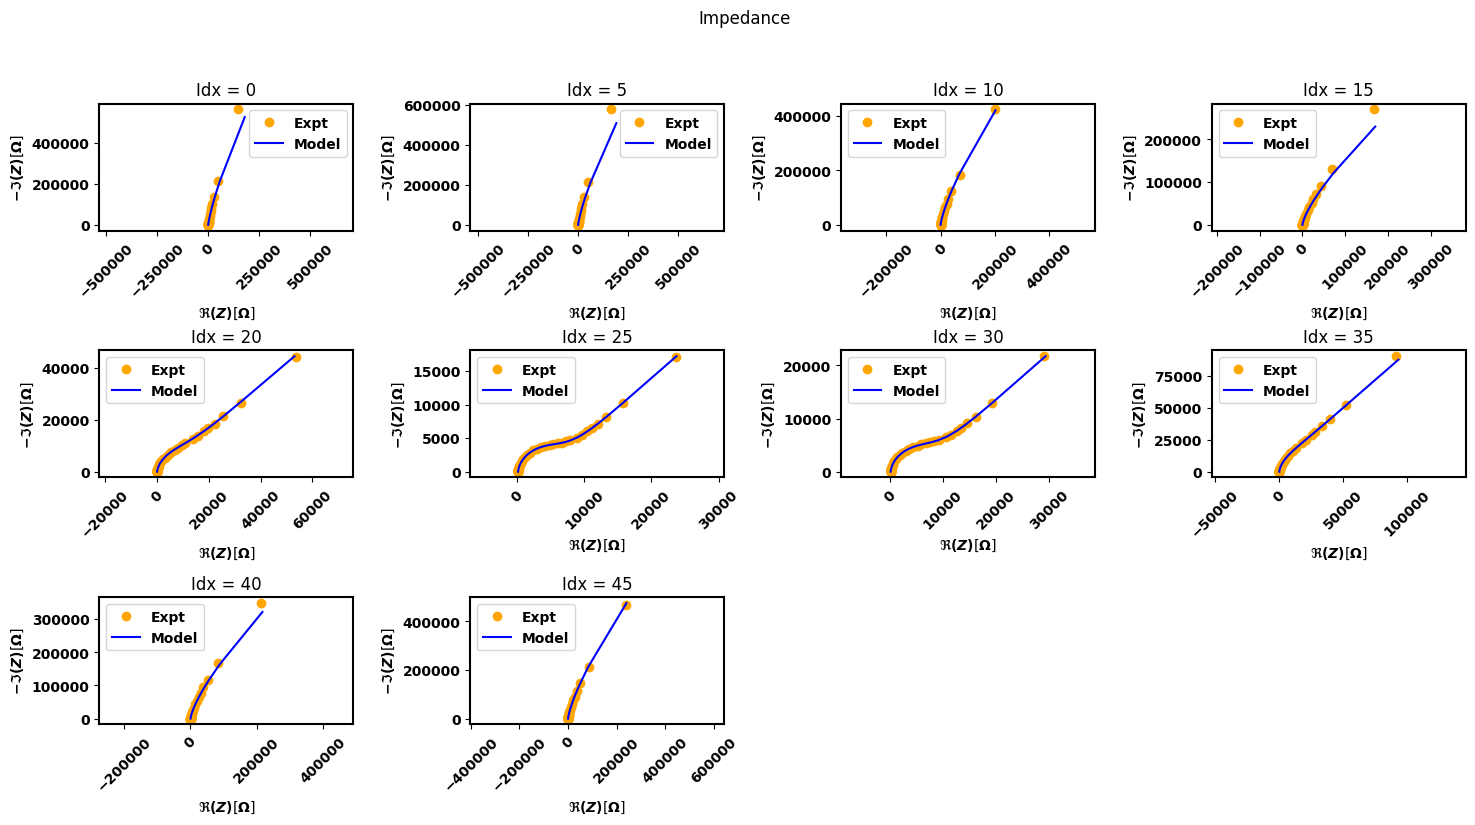

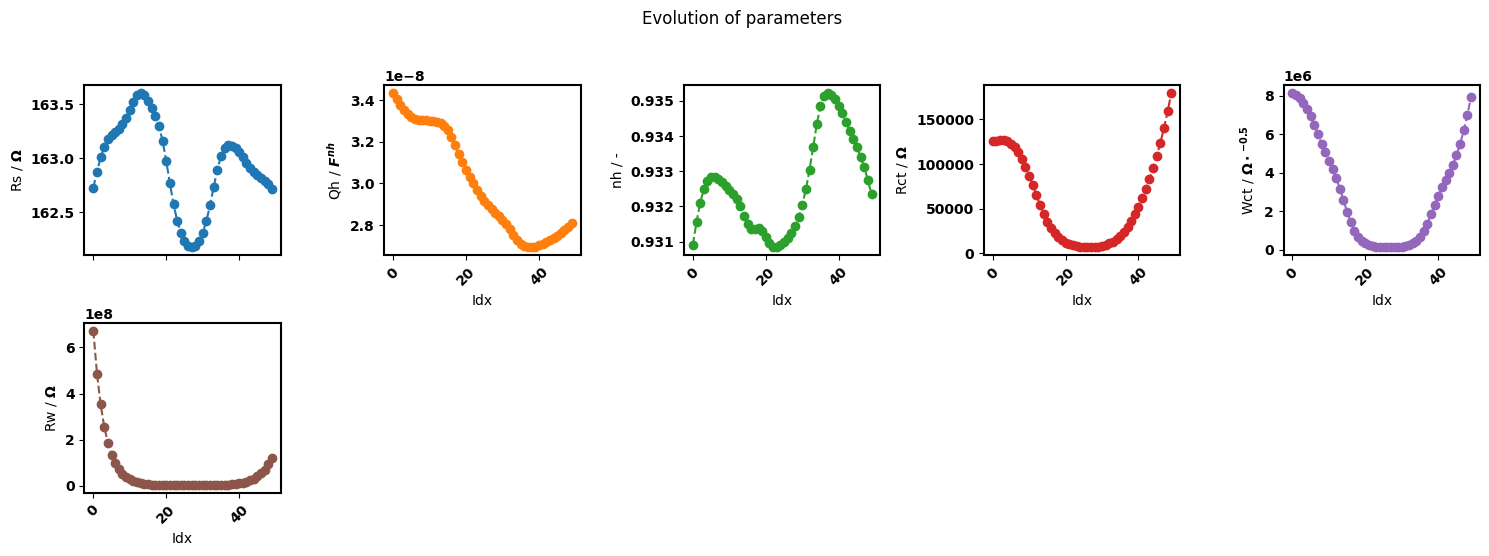

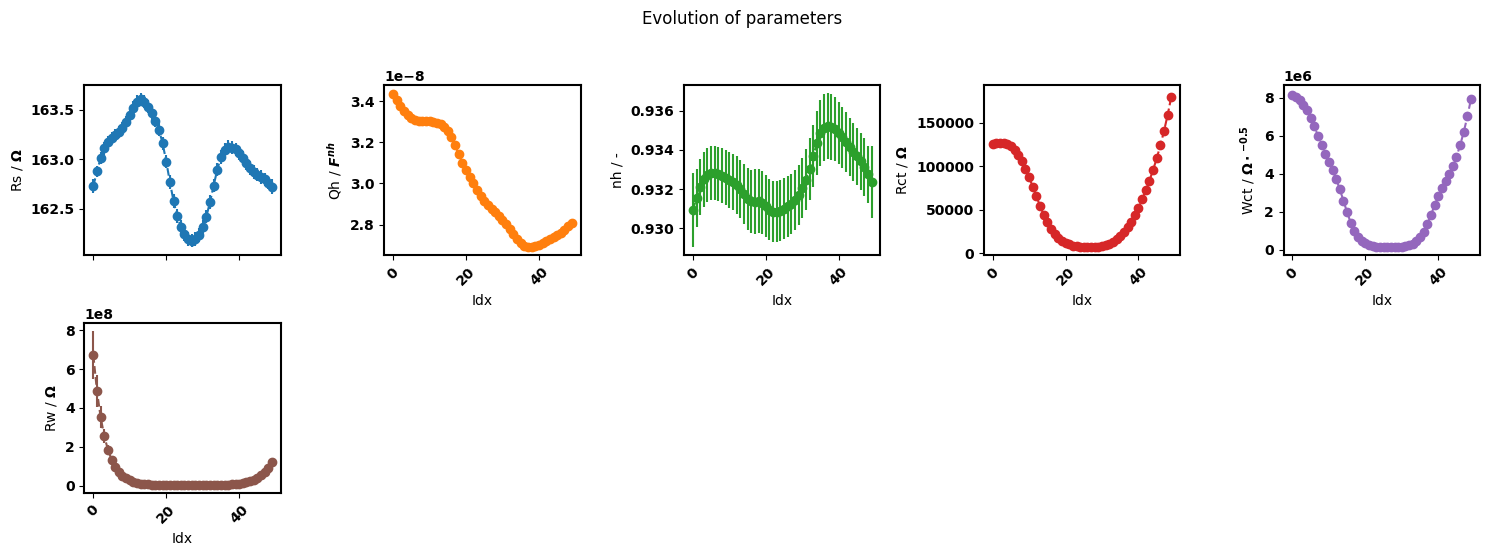

In [8]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_simultaneous(method = 'bfgs')
eis_redox_sigma.plot_nyquist(5)
eis_redox_sigma.plot_params(labels=labels)
eis_redox_sigma.plot_params(True, labels=labels)

Iteration : 507, Loss : 2.42204e+01
Optimization complete
total time is 0:00:11.278105 

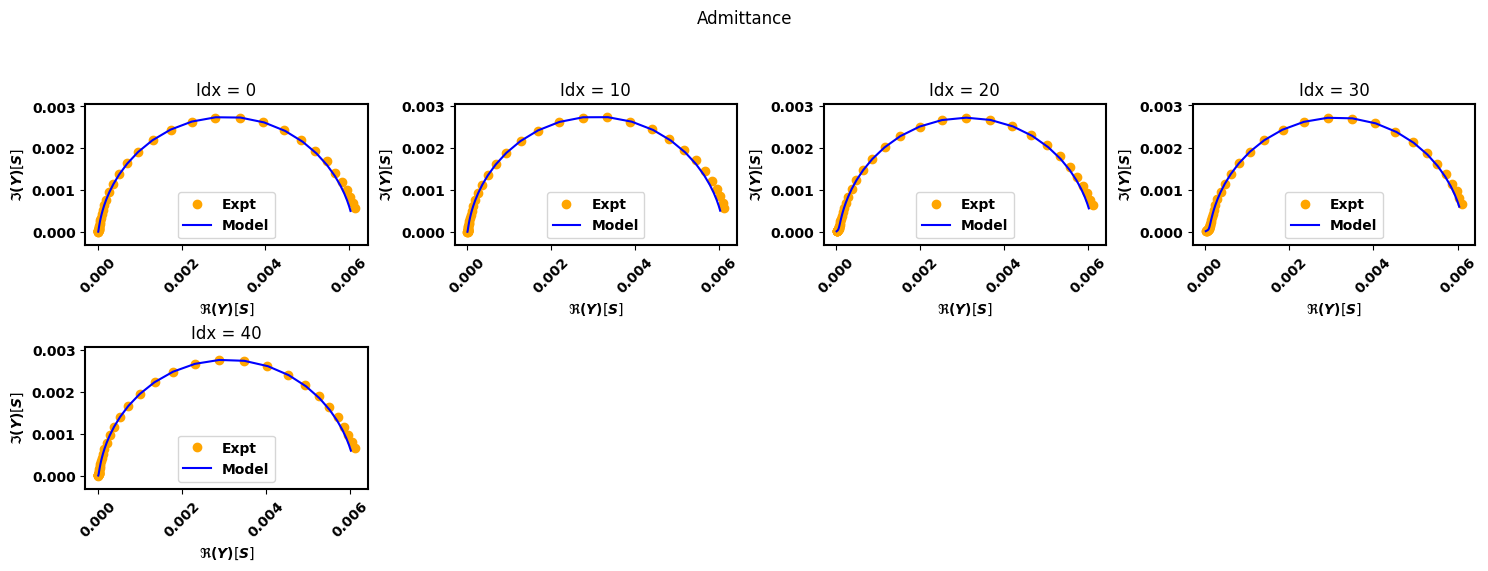

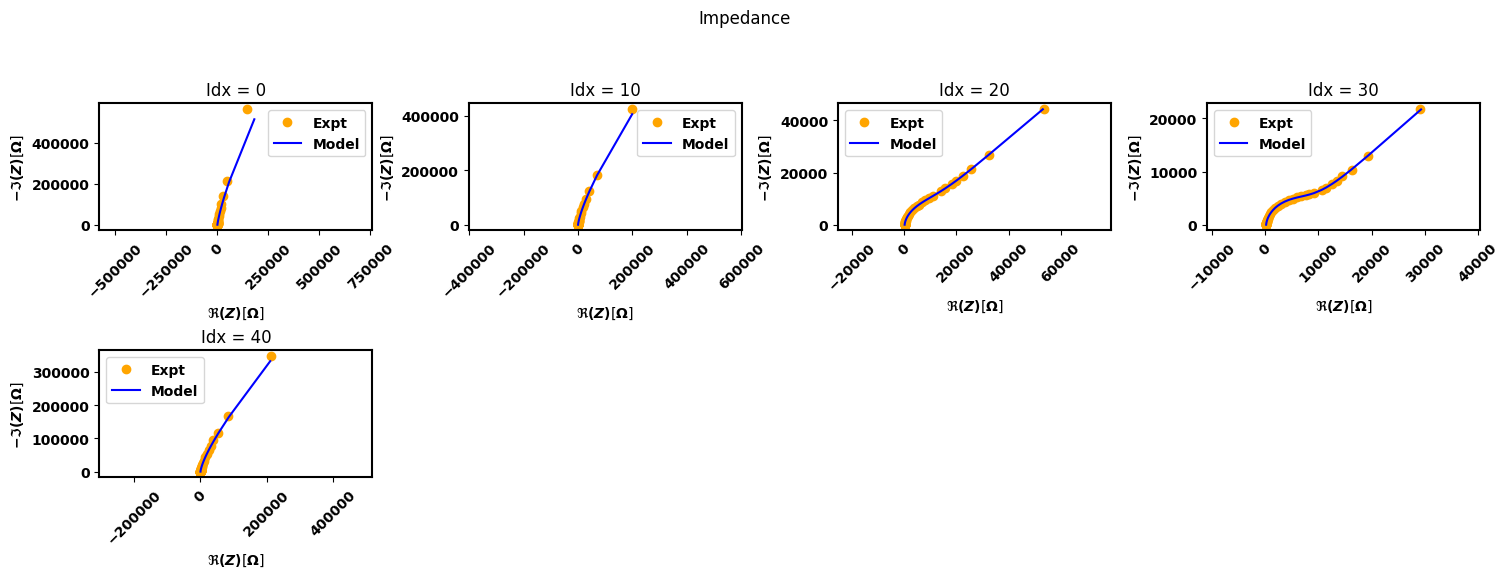

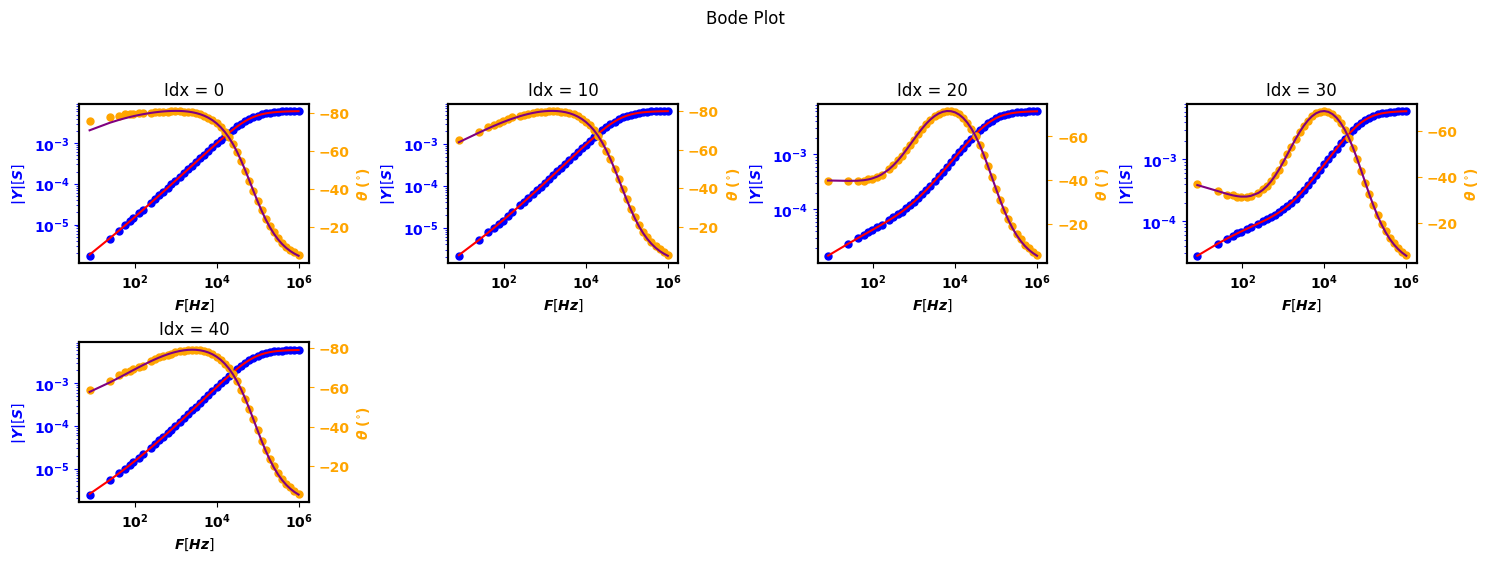

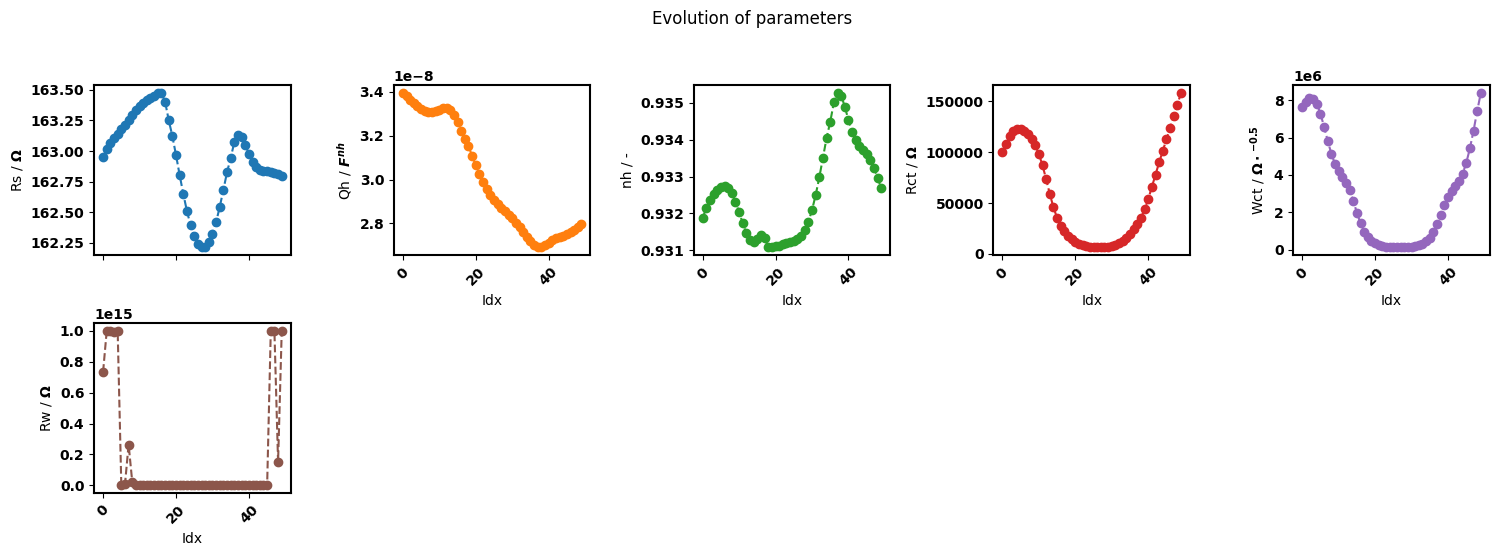

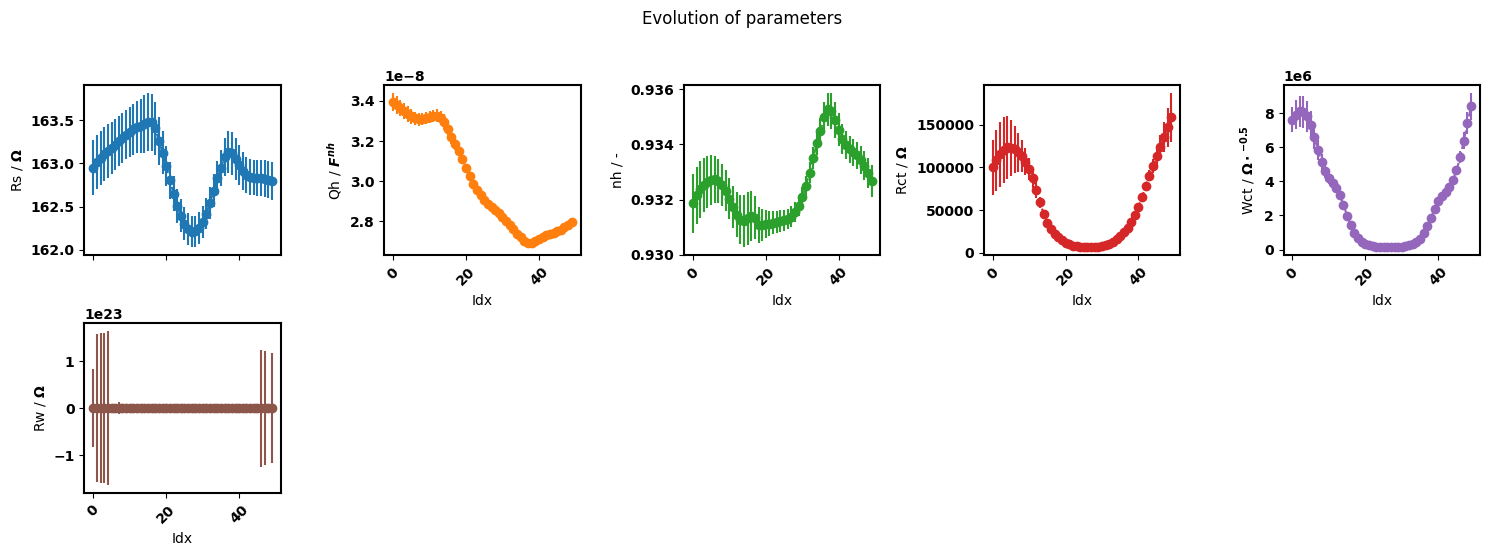

In [9]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_simultaneous_zero()
eis_redox_sigma.plot_nyquist(10)
eis_redox_sigma.plot_bode(steps = 10)
eis_redox_sigma.plot_params(labels=labels)
eis_redox_sigma.plot_params(True, labels=labels)

2. Using the modulus as weighting

There are many cases where we do not have the data for the standard deviation of the admittance or impedance. ``pymultieis`` offers other weighting options. 
In this second example we shall fit using the modulus as the weighting. All you need do is set the weight to the string "modulus".

Iteration : 0, Loss : 4.11945e-01
Iteration : 723, Loss : 3.74469e-05
Optimization complete
total time is 0:01:03.948782 

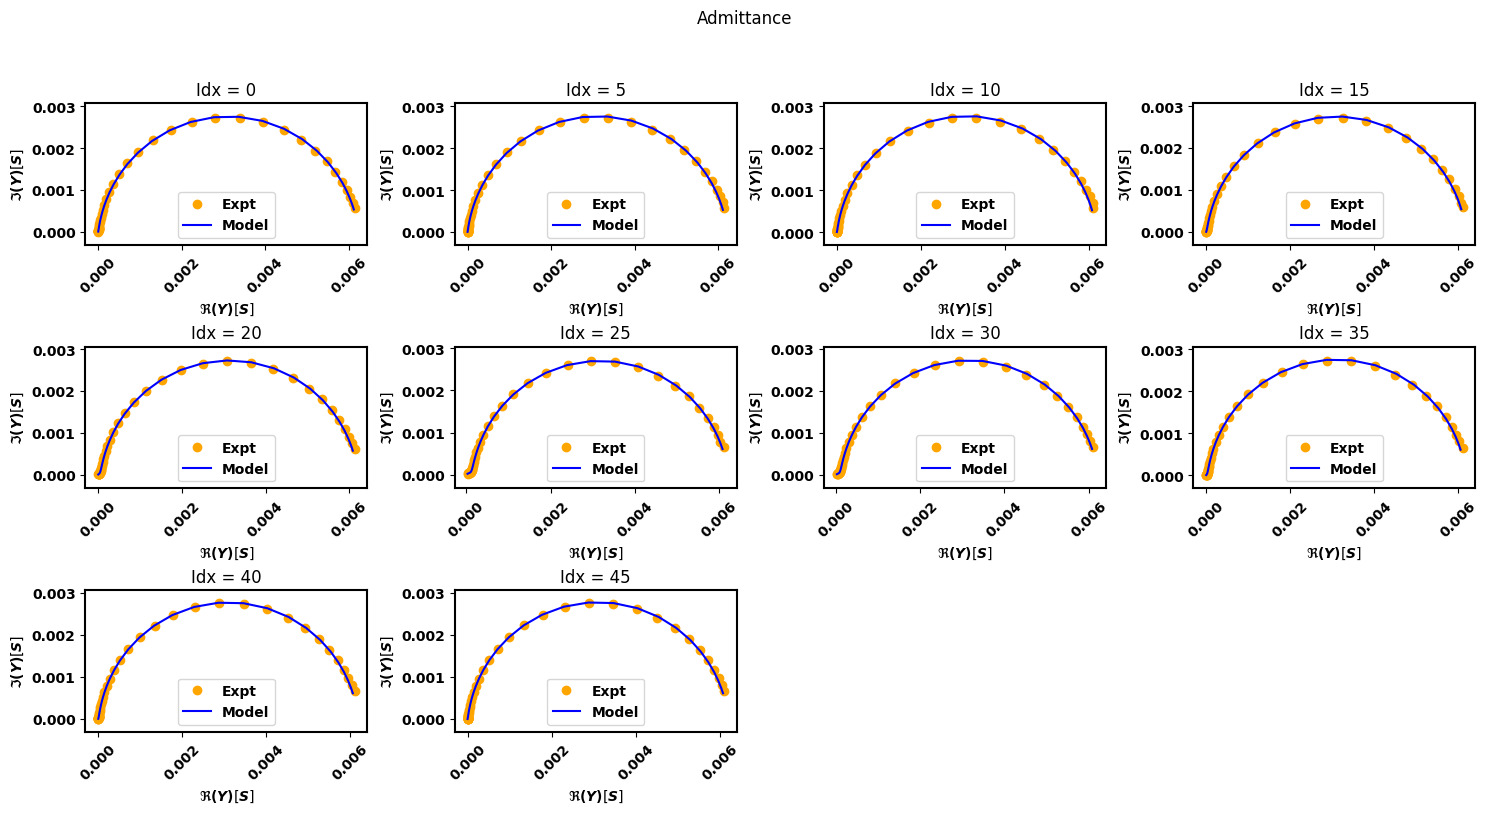

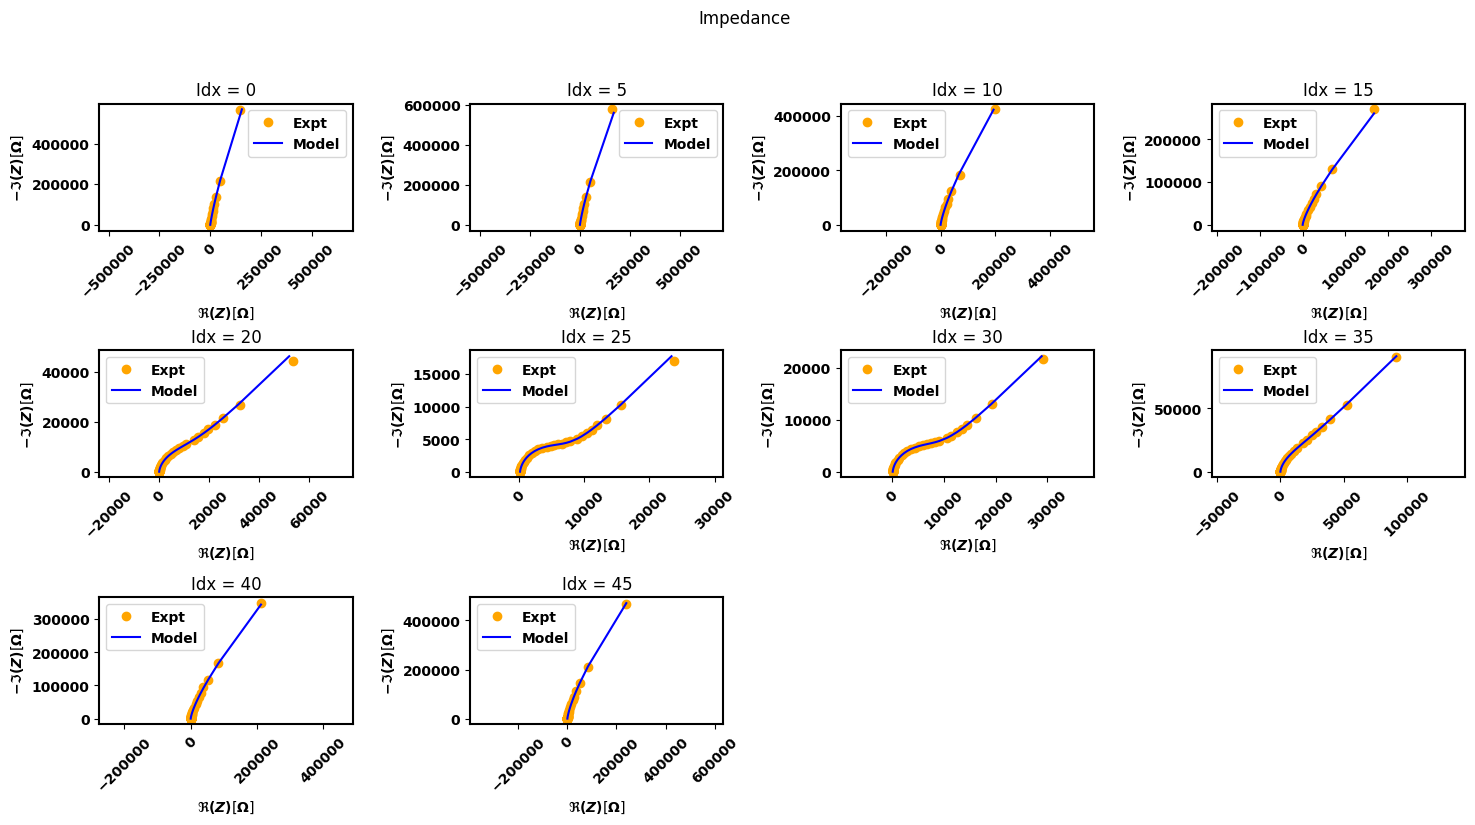

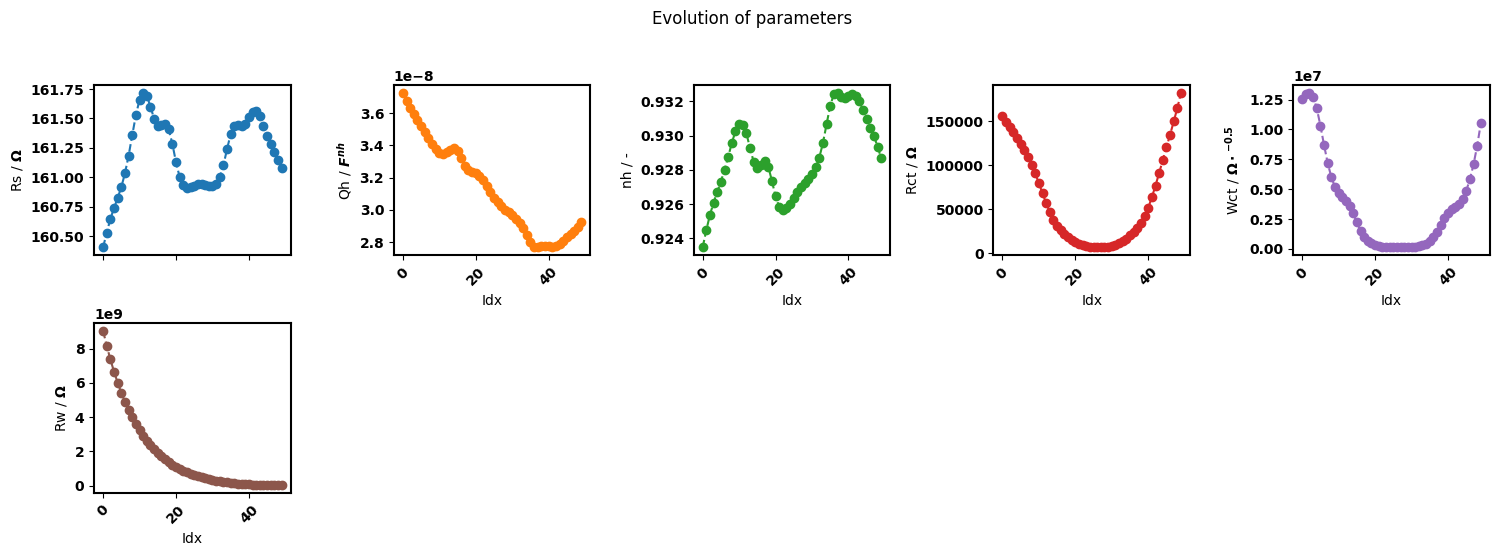

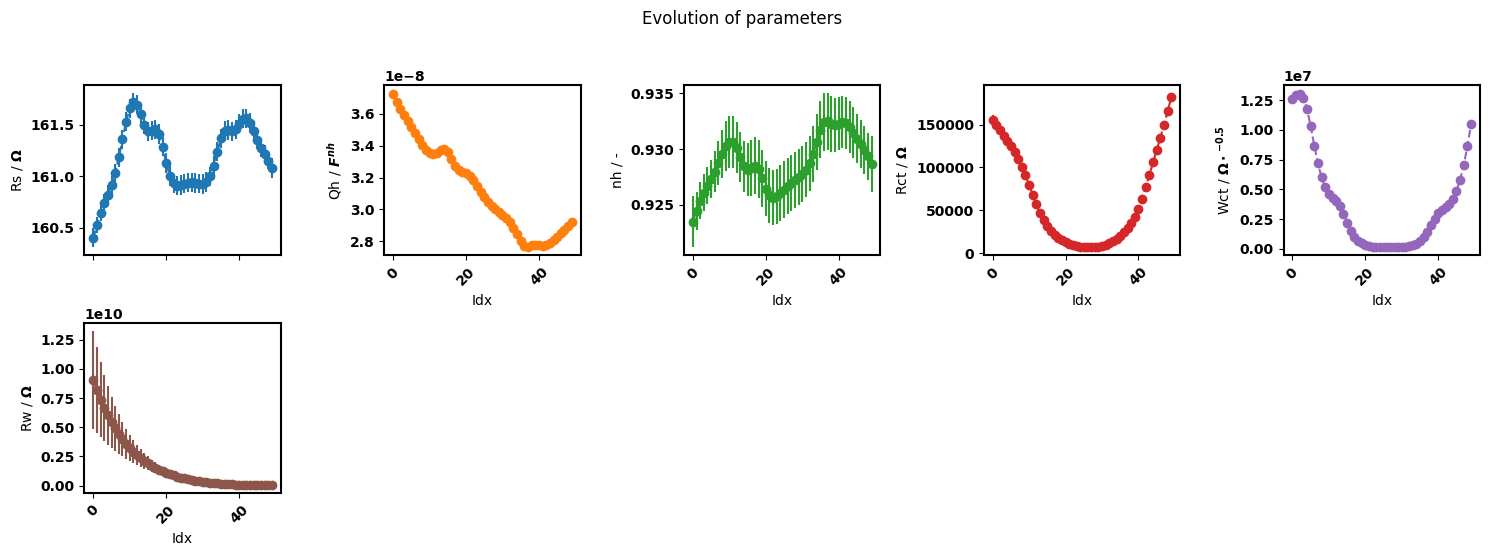

In [10]:
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'bfgs')
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(labels=labels)
eis_redox_modulus.plot_params(True, labels=labels)

Iteration : 900, Loss : 2.78219e-05
Optimization complete
total time is 0:00:20.417138 

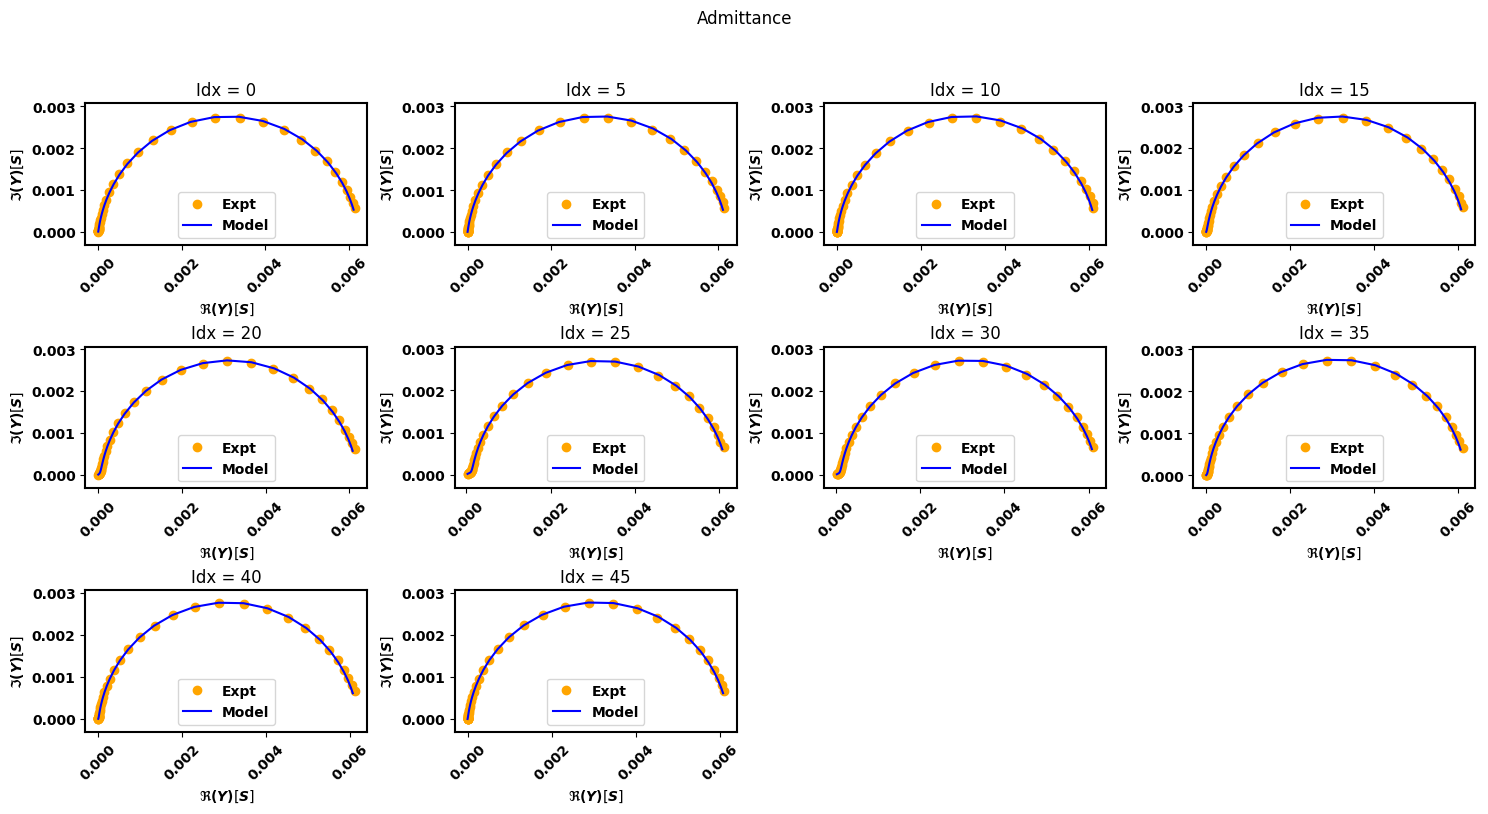

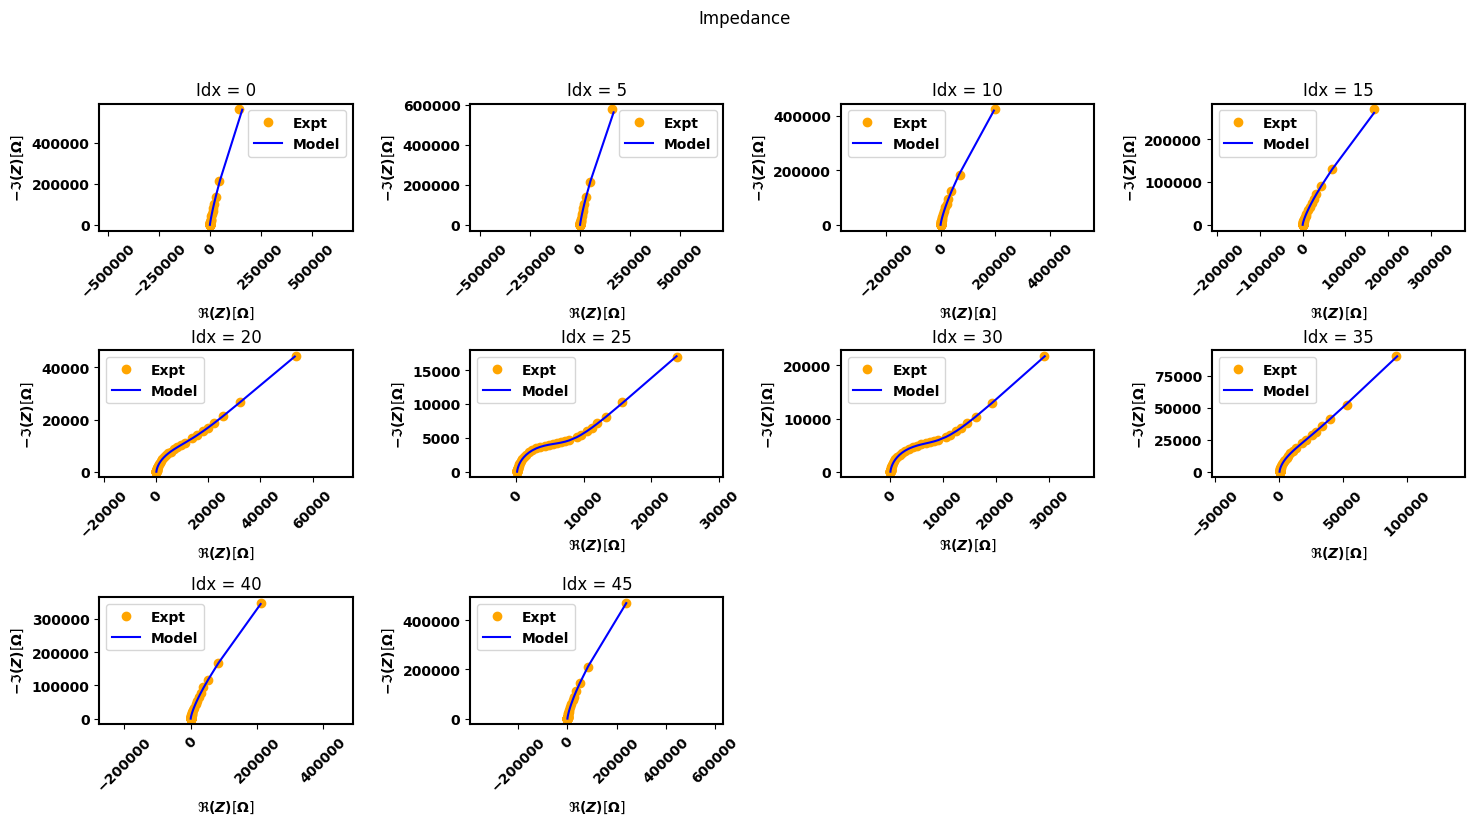

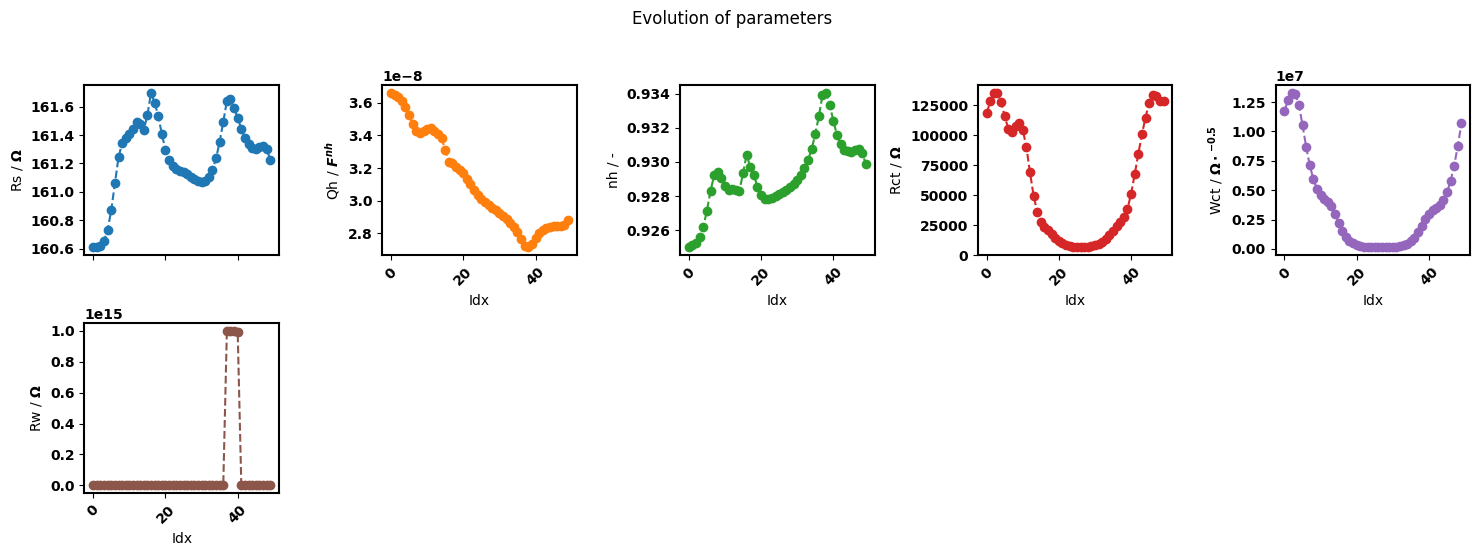

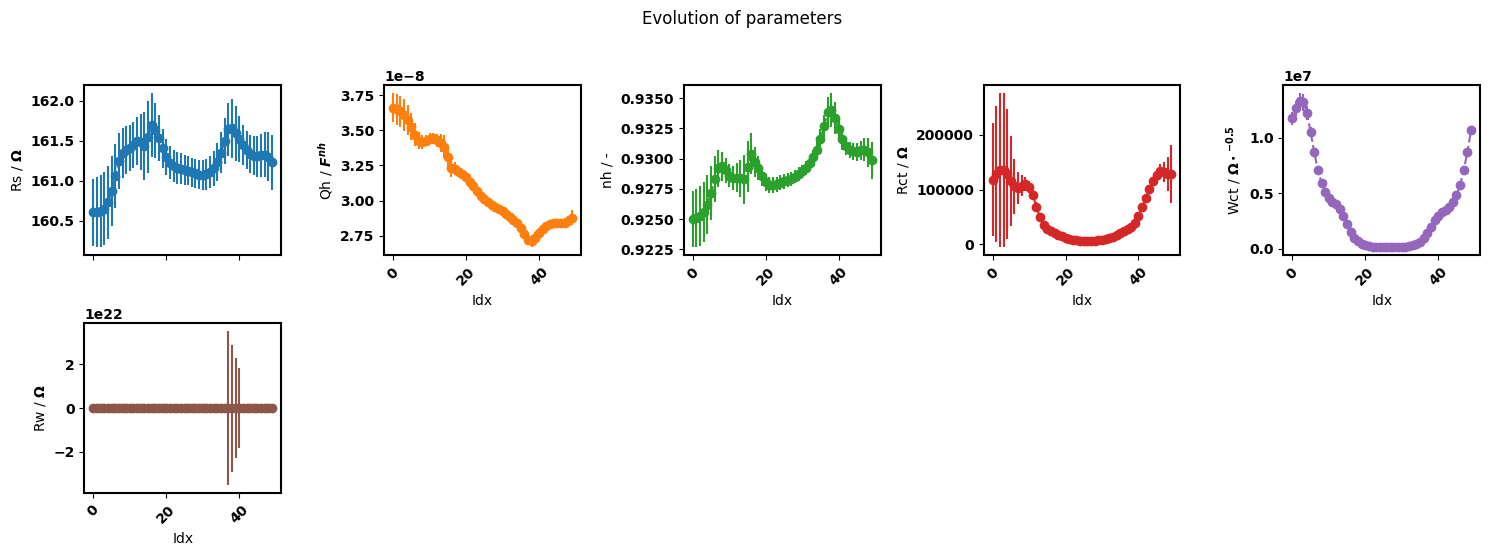

In [11]:
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous_zero()
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(labels=labels)
eis_redox_modulus.plot_params(True, labels=labels)

In [12]:
# Reinstantiate class
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_sequential(indices=None)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

Iteration : 0, Loss : 4.11945e-01
Iteration : 1000, Loss : 2.91340e-04
Iteration : 1530, Loss : 2.06343e-04

AttributeError: hess_inv

3. Fitting with the stochastic option

Iteration : 0, Loss : 4.11945e-01
Iteration : 788, Loss : 3.77742e-05
Optimization complete
total time is 0:00:19.902758 fitting spectra 0
fitting spectra 1
fitting spectra 2
fitting spectra 3
fitting spectra 4
fitting spectra 5
fitting spectra 6
fitting spectra 7
fitting spectra 8
fitting spectra 9
fitting spectra 10
fitting spectra 11
fitting spectra 12
fitting spectra 13
fitting spectra 14
fitting spectra 15
fitting spectra 16
fitting spectra 17
fitting spectra 18
fitting spectra 19
fitting spectra 20
fitting spectra 21
fitting spectra 22
fitting spectra 23
fitting spectra 24
fitting spectra 25
fitting spectra 26
fitting spectra 27
fitting spectra 28
fitting spectra 29
fitting spectra 30
fitting spectra 31
fitting spectra 32
fitting spectra 33
fitting spectra 34
fitting spectra 35
fitting spectra 36
fitting spectra 37
fitting spectra 38
fitting spectra 39
fitting spectra 40
fitting spectra 41
fitting spectra 42
fitting spectra 43
fitting spectra 44
fitting spectra 45
fitting spectra

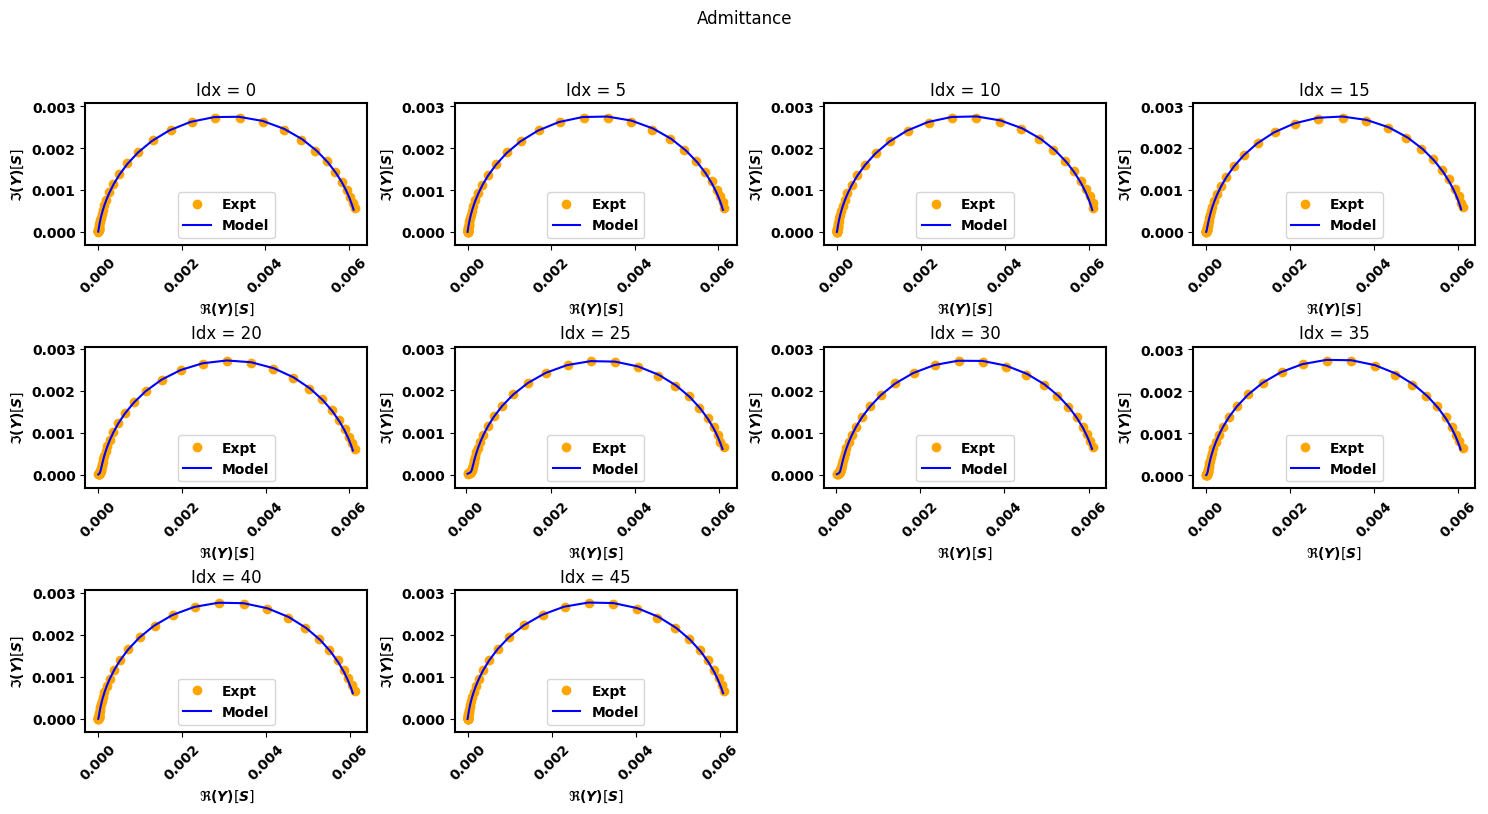

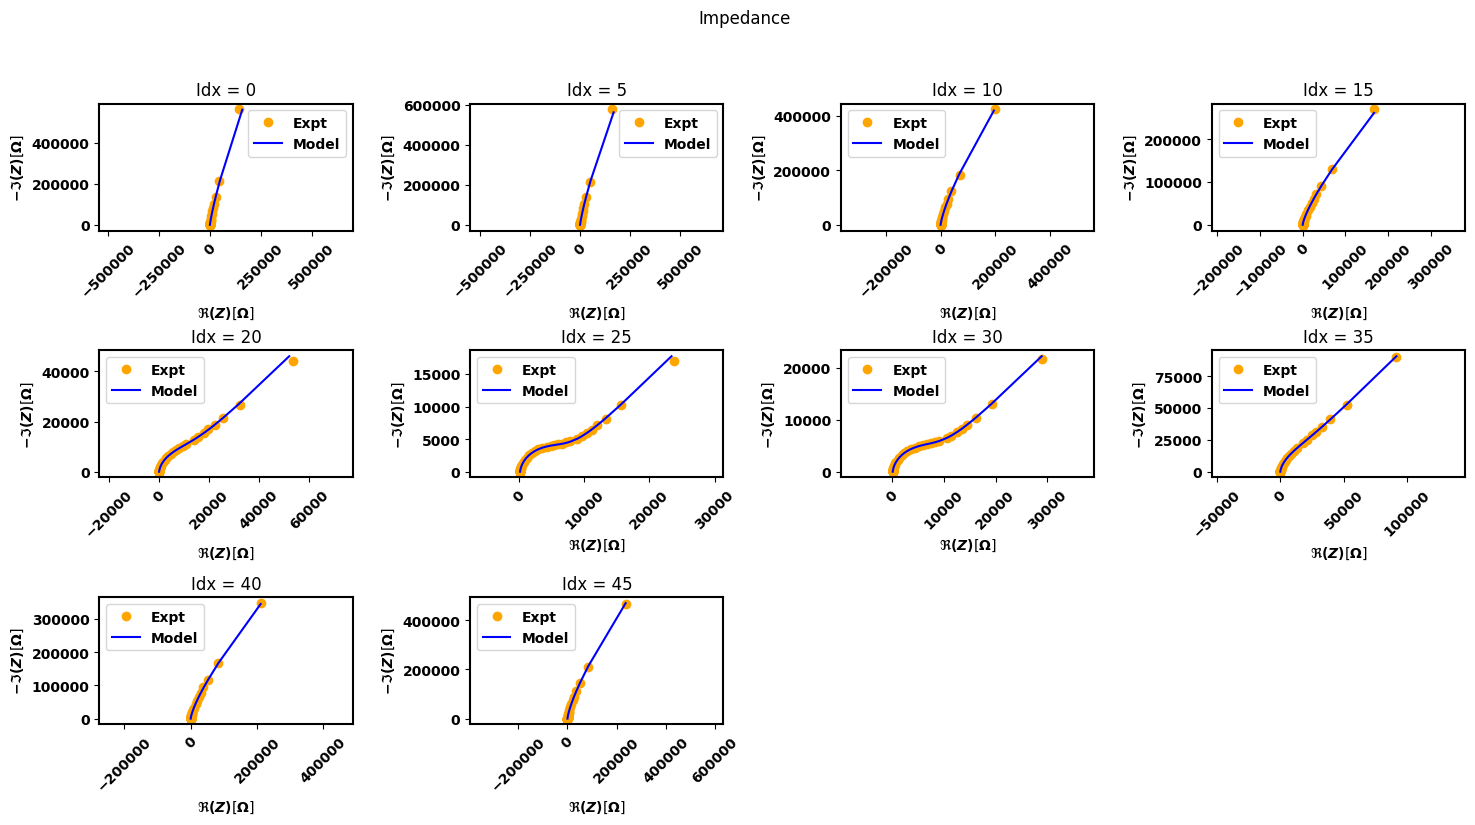

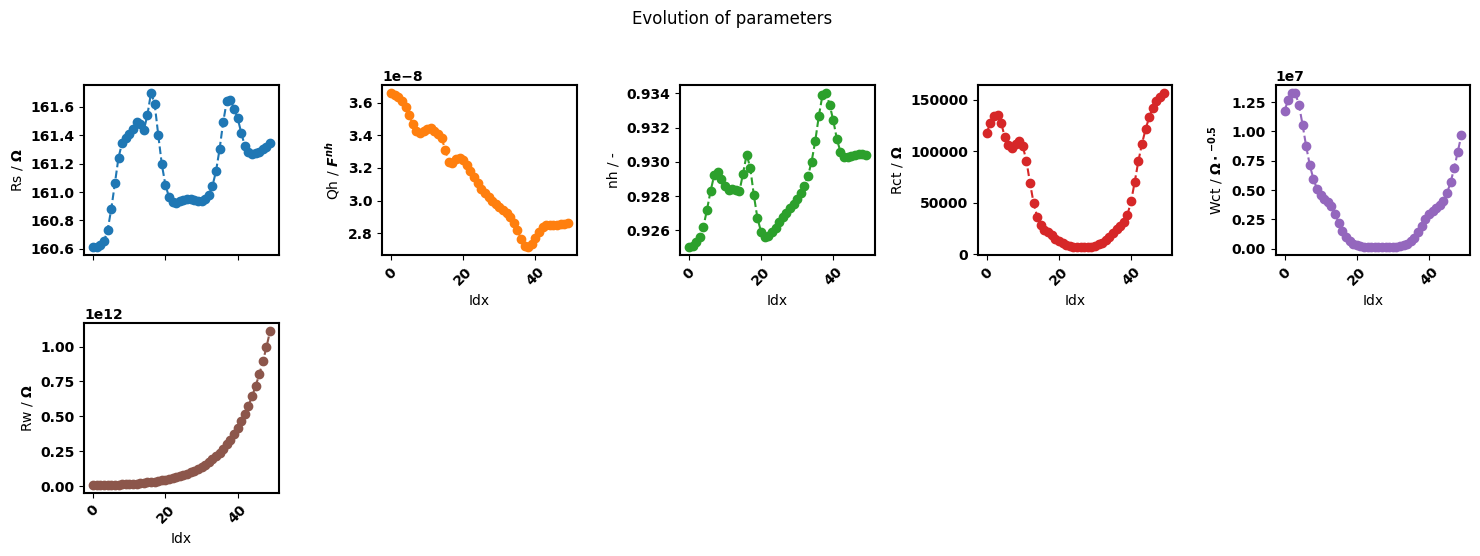

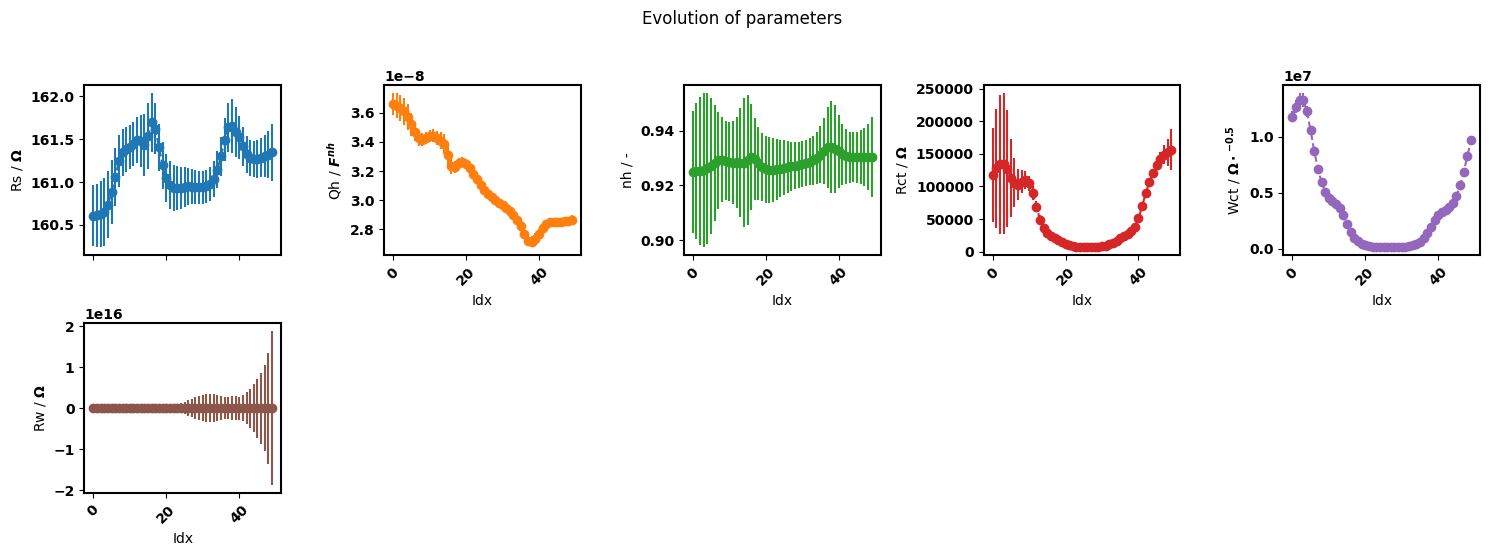

In [ ]:
# Reinstantiate class and fit stochastic
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_stochastic()
eis_redox_modulus.plot_nyquist(10)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

0: loss=4.119e-01
10000: loss=4.565e-05
20000: loss=3.769e-05
30000: loss=3.753e-05
40000: loss=3.750e-05
50000: loss=3.748e-05
60000: loss=3.747e-05
70000: loss=3.747e-05
80000: loss=3.746e-05
90000: loss=3.746e-05
Optimization complete
total time is 0:11:40.870153 

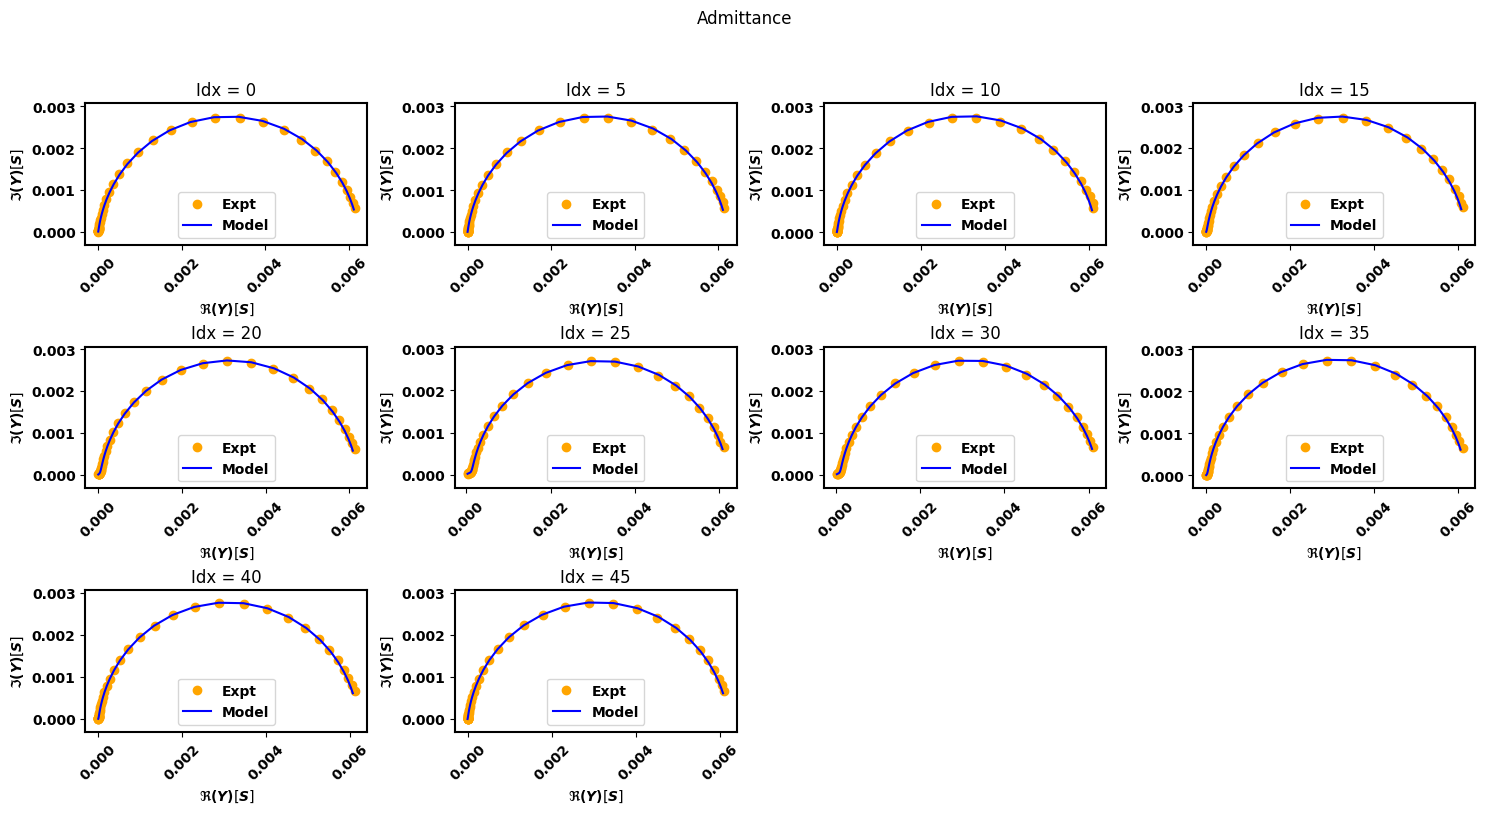

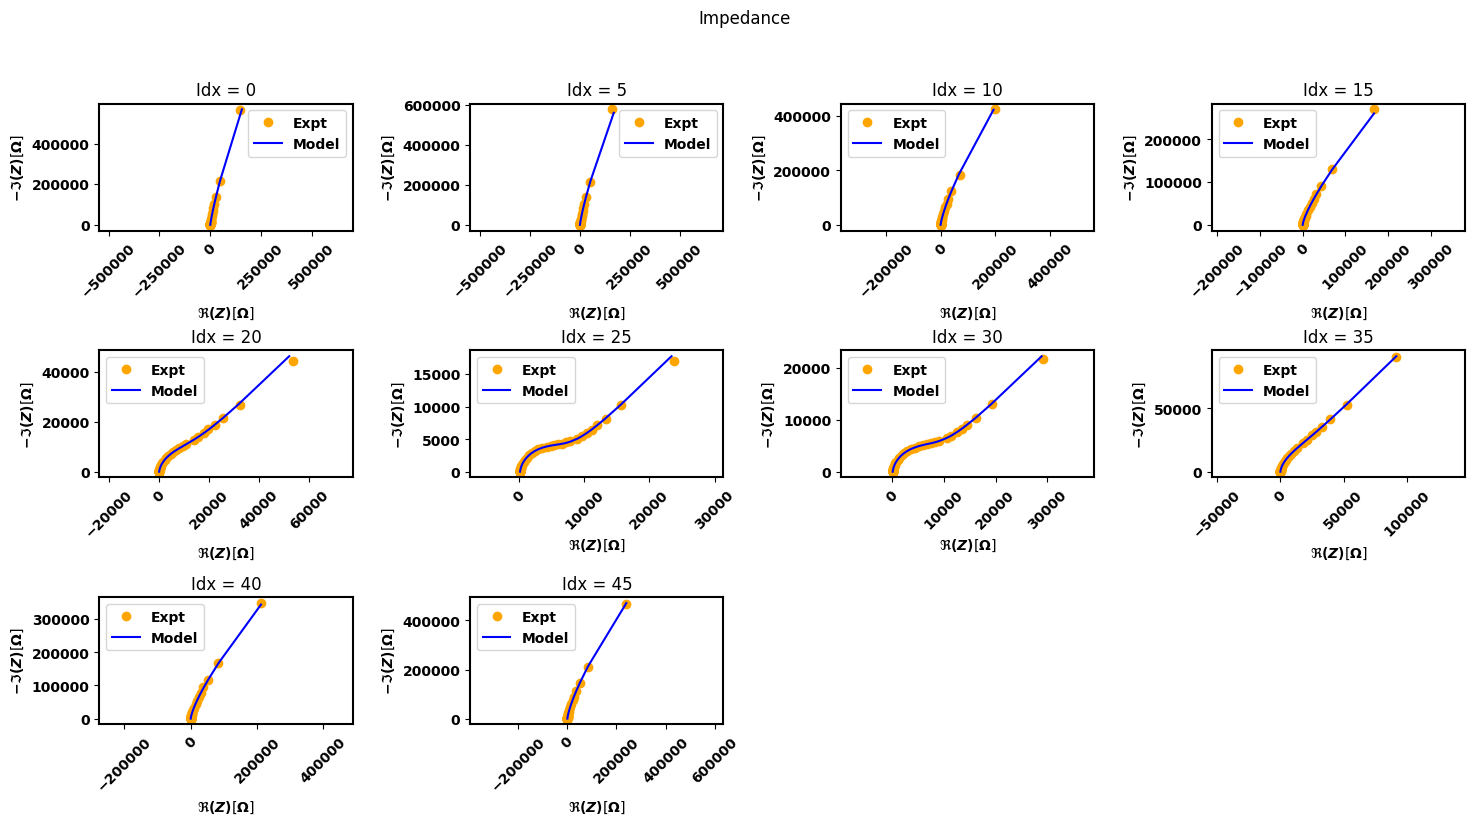

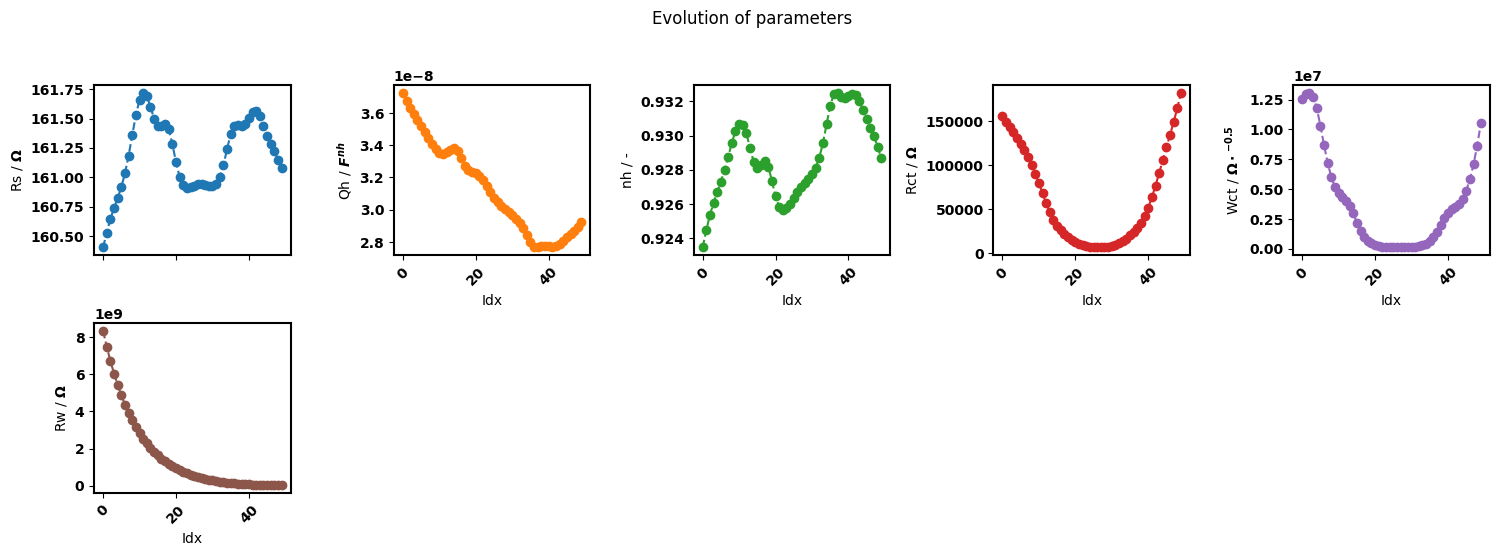

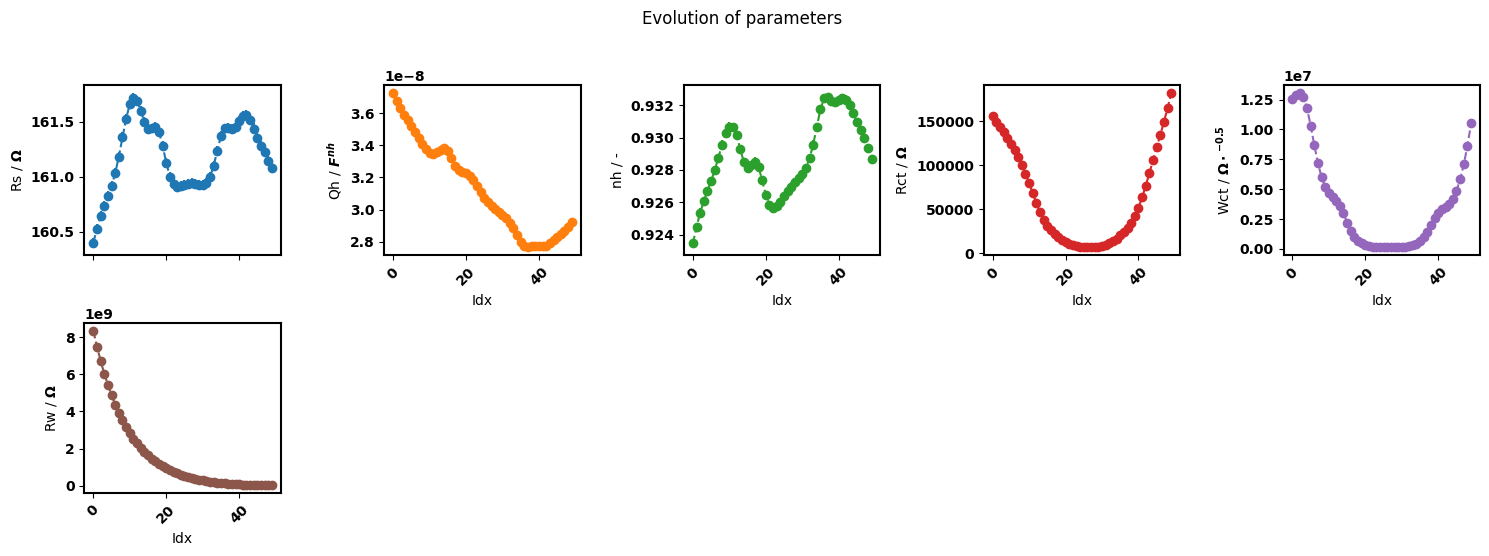

In [ ]:
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_sequential(indices=None)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

4. Running the Bootstrap MonteCarlo option

In [ ]:
# Reinstantiate class and fit stochastic
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.compute_perr_mc(n_boots=500)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

5. Keeping a parameter constant

In [ ]:
# Reinstantiate class and fit keeping a parameter constant
smf_const = smf_modulus.clone()
smf_const[0] = torch.inf
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_const, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

4. Saving the plots

In [ ]:
eis_redox_modulus.save_plot_nyquist(steps=10, fname='example_results')
eis_redox_modulus.save_plot_bode(steps=10, fname='example_results')
eis_redox_modulus.save_plot_params(False, fname='example_results')

5. saving the results

In [ ]:
eis_redox_modulus.save_results(fname='example_results')